# Predicting US Median Housing Sales Price

## Goal

The goal of this project is to predict median US house sales prices using the FRED (Federal Reserve Economic Data) timeseries API and Python implementations of machine learning models.

## Summary

This README provides an overview of the process to fetch and explore data from the FRED timeseries API and use Python for predictive modeling. The outlined steps will guide you through the process of data retrieval, exploration, and implementation of machine learning models for predicting median US house sales prices.

### Authors

- Joshua Lee
- Evan Grillo

### Imports Section

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from dotenv import load_dotenv
import os
load_dotenv()

from fredapi import Fred

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import numpy as np


from scipy import stats

2024-02-15 20:46:14.732691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Env Variable &amp; Create FRED instance

In [2]:
# env variable
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

# Initialization

The `fred_timeseries_mapping` dictionary serves as a mapping between FRED (Federal Reserve Economic Data) timeseries API codes and their corresponding names.

Each timeseries in this mapping represents economic indicators, with reporting frequencies ranging from the early 20th century through the current week.

## Process Overview

1. **Data Retrieval:**
   - The `fred_timeseries_mapping` is a dictionary containing FRED timeseries API codes as keys and their corresponding names as values.

2. **Data Collection:**
   - We initialize a list to store data frames. Iterating through the dictionary, we request each timeseries code and group the data by the year and quarter. This grouping ensures that the index for each series aligns, accommodating inconsistent reporting frequencies.

3. **DataFrame Construction:**
   - After iterating through the dictionary, we create a main dataframe by concatenating the list of dataframes. The FRED Python wrapper facilitates this process by building HTTP URLs and handling tasks like processing datetime data, setting it as the index.

4. **Handling Missing Data:**
   - We use the `dropna` function to remove any missing data points, ensuring a clean and complete dataset.

This initialization process lays the foundation for subsequent data analysis and machine learning tasks. The resulting dataframe is ready for feature engineering, model training, and predictive analytics.


In [3]:
fred_timeseries_mapping = {
    'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
    'HOUST': 'New Privately-Owned Housing Units Started: Total Units',
    'CSUSHPINSA': 'S&P CoreLogic Case-Shiller U.S. National Home Price Index',
    'HPIPONM226S': 'Purchase Only House Price Index for the United States',
    # 'WSCNDW01USQ470S': 'Work Started: Construction: Dwellings and Residential Buildings: Total for United States',
    'ETOTALUSQ176N': 'Housing Inventory Estimate: Total Housing Units in the United States',
    'USSTHPI': 'All-Transactions House Price Index for the United States',
    'WPUSI012011': 'Producer Price Index by Commodity: Special Indexes: Construction Materials',
    'ILSTHPI': 'All-Transactions House Price Index for Illinois',
    'MORTGAGE30US': '30-Year Fixed Rate Mortgage Average in the United States',
    'MORTGAGE15US': '15-Year Fixed Rate Mortgage Average in the United States',
    'MSACSR': 'Monthly Supply of New Houses in the United States',
    'MSPUS': 'Median Sales Price of Houses Sold for the United States'
}

start = "2000-01-01"
#end

dfs = []

for s in list(fred_timeseries_mapping.keys()):
    data = fred.get_series(s, observation_start=start)
    df = pd.DataFrame(data)
    # get max or min to remove outliers

    df_grouped = df.groupby(by=[df.index.year, df.index.quarter]).mean()
    # display(df.isnull().any())
    dfs.append(df_grouped)
    
housing_data_df = pd.concat(dfs, axis=1)
housing_data_df.columns = list(fred_timeseries_mapping.keys())
housing_data_df.dropna(inplace=True)

display(housing_data_df.head(10))
display(housing_data_df.tail(10))

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2000 2  171.433333  1586.666667  103.699000   139.566667       116047.0   
     3  173.000000  1503.666667  106.459333   141.780000       116482.0   
     4  174.233333  1544.000000  108.270000   144.200000       116914.0   
2001 1  175.900000  1605.000000  109.750000   146.910000       117347.0   
     2  177.133333  1630.000000  112.241000   149.316667       117786.0   
     3  177.633333  1599.666667  114.893000   151.590000       118216.0   
     4  177.500000  1570.000000  115.858667   153.943333       118635.0   
2002 1  178.066667  1723.000000  117.094000   156.560000       119061.0   
     2  179.466667  1691.000000  120.776333   159.420000       119483.0   
     3  180.433333  1697.333333  124.636667   162.483333       119909.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2000 2   233.89   145.166667   245.58      8.316154      7.991538  4.533333   
     3   238.16   143.833333   249.63      8.020000      7.733077  4.166667   
     4   241.80   142.833333   252.46      7.620769      7.294615  3.933333   
2001 1   247.79   142.266667   255.77      7.006923      6.589231  3.766667   
     2   251.94   143.666667   260.21      7.130000      6.660000  4.033333   
     3   255.85   143.233333   265.05      6.963846      6.506923  4.333333   
     4   259.02   142.033333   267.50      6.770769      6.253077  4.066667   
2002 1   262.73   142.466667   272.12      6.971538      6.461538  4.100000   
     2   267.21   143.866667   276.94      6.813077      6.286154  4.166667   
     3   272.51   145.066667   280.51      6.289231      5.712308  4.033333   

           MSPUS  
2000 2  163200.0  
     3  168800.0  
     4  172900.0  
2001 1  169800.0  
     2  179000.0  
     3  172500.0  
     4  171100.0  
2002 1  188700.0  
     2  187200.0  
     3  178100.0

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2021 2  268.622667  1581.666667  255.498000   333.000000       141927.0   
     3  272.890000  1576.333333  268.593000   348.133333       142288.0   
     4  278.680333  1690.333333  276.106667   361.763333       142697.0   
2022 1  284.826000  1717.666667  288.086000   377.643333       143105.0   
     2  291.706333  1635.666667  305.479000   390.660000       143514.0   
     3  295.509000  1446.333333  303.747333   390.126667       143923.0   
     4  298.441000  1405.333333  296.664000   391.553333       144332.0   
2023 1  301.203000  1385.333333  294.520000   394.996667       144740.0   
     2  303.466667  1449.666667  305.039667   403.173333       145149.0   
     3  306.034333  1370.666667  311.367333   412.006667       145558.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2021 2   510.74   304.466667   385.96      3.003846      2.309231  5.366667   
     3   539.20   314.587000   399.44      2.872143      2.171429  6.066667   
     4   557.79   328.697333   408.73      3.079231      2.338462  6.133333   
2022 1   578.36   345.059000   419.56      3.822308      3.044615  6.333333   
     2   617.03   348.867000   445.57      5.266154      4.450769  8.766667   
     3   627.42   342.002333   450.94      5.623077      4.880769  9.500000   
     4   622.78   330.204667   446.16      6.664615      5.959231  9.200000   
2023 1   625.78   329.866333   449.78      6.372308      5.564615  8.200000   
     2   645.38   336.058333   468.27      6.510769      5.870769  7.433333   
     3   657.32   333.466000   479.38      7.040000      6.396154  7.500000   

           MSPUS  
2021 2  382600.0  
     3  411200.0  
     4  423600.0  
2022 1  433100.0  
     2  449300.0  
     3  468000.0  
     4  479500.0  
2023 1  429000.0  
     2  418500.0  
     3  435400.0

<Axes: >

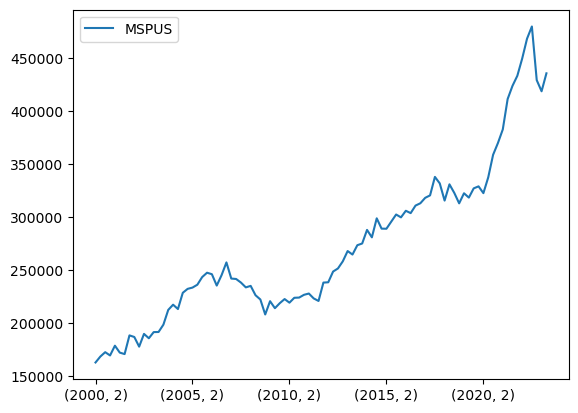

In [4]:
housing_data_df[['MSPUS']].plot()

# Correlation Analysis

## Objective

The initial phase of this analysis aimed to investigate the predictive potential of using the feature MSACSR ('Monthly Supply of New Houses in the United States') to forecast MSPUS ('Median Sales Price of Houses Sold for the United States'). To enhance this exploration, additional timeseries from FRED were incorporated, considering potential correlations with the target variable, MSPUS.

## Methodology

1. **Feature Selection:**
   - The primary focus was on MSACSR as a potential predictor for MSPUS. Other timeseries from FRED were introduced to expand the set of features and capture potential correlations.

2. **Correlation Calculation:**
   - The analysis proceeded to calculate the correlation between the selected features and the target variable (MSPUS). The correlation values were then sorted from high to low.

3. **Visualization:**
   - To provide a clear representation of the correlation results, the sorted correlation values were visualized. This step aids in understanding the strength and direction of relationships between features and the target variable.

## Next Steps

The insights gained from this correlation analysis lay the groundwork for further exploration. The identified relationships between features and the target variable will inform subsequent steps in feature engineering, model selection, and the overall predictive modeling process.


In [5]:
# Look at correlation between target and features
target_column = 'MSPUS'

# Calculate correlations for each series with the target
correlations = housing_data_df.copy() \
    .drop(columns=target_column) \
    .corrwith(housing_data_df[target_column]) \
    .abs() \
    .sort_values(ascending=False)
print(correlations)

WPUSI012011      0.959855
HPIPONM226S      0.956565
CSUSHPINSA       0.955770
CPIAUCSL         0.949600
USSTHPI          0.946107
ETOTALUSQ176N    0.904010
ILSTHPI          0.805625
MORTGAGE15US     0.466533
MORTGAGE30US     0.453050
MSACSR           0.217826
HOUST            0.030514
dtype: float64


## Explain this

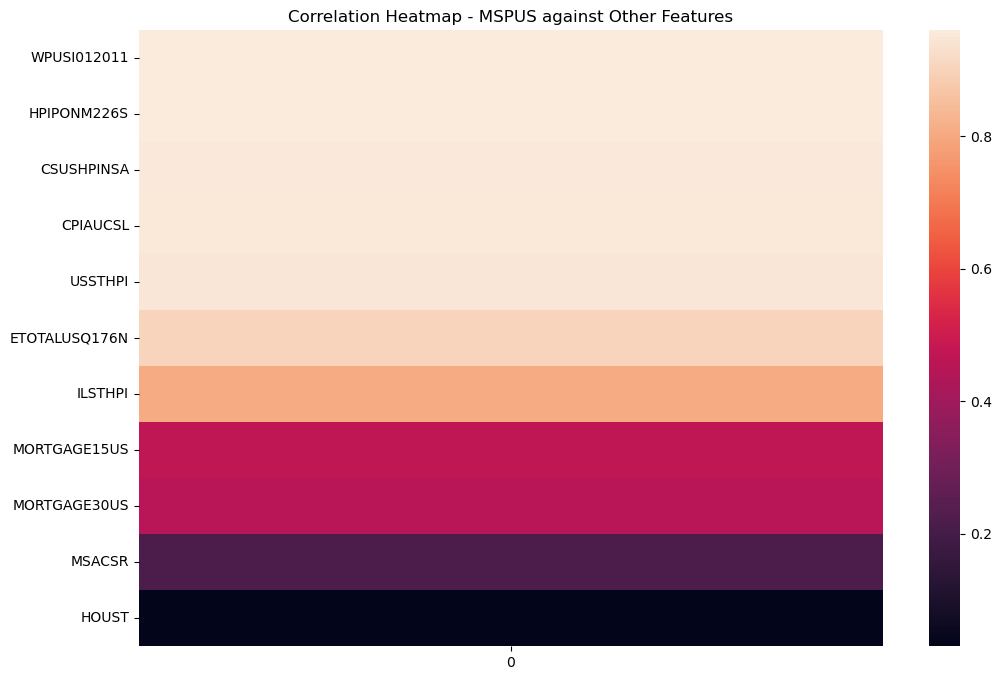

In [6]:
# Visualize correlation
cols = housing_data_df.columns.drop('MSPUS')

correlation_matrix = housing_data_df[cols].corrwith(housing_data_df['MSPUS']) \
    .abs() \
    .sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.to_frame())
plt.title(f"Correlation Heatmap - {'MSPUS'} against Other Features")
plt.show()

## Determine if candidate for Linear Regression

#### Find best fit line

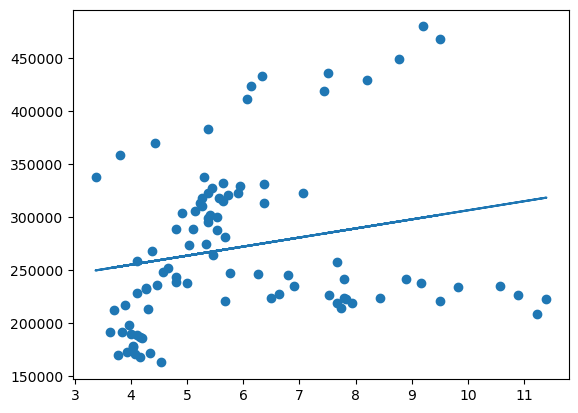

0.21782562588367504 Weak candidate for Linear Regression


In [7]:
#Linear Regression
x_lr = housing_data_df['MSACSR']
y_lr = housing_data_df['MSPUS']

slope, intercept, r, p, std_err = stats.linregress(x_lr, y_lr)

plt.scatter(x_lr, y_lr)
plt.plot(x_lr, slope * x_lr + intercept)
plt.show()

if r > .8 or r < -.8:
    print(f'{r}: Good candidate for Linear Regression')
else:
    print(f'{r} Weak candidate for Linear Regression')

## Determine if candidate for Polynomial Regression

#### like linear regression, it seeks to find a 'best fit' line but not a linear line

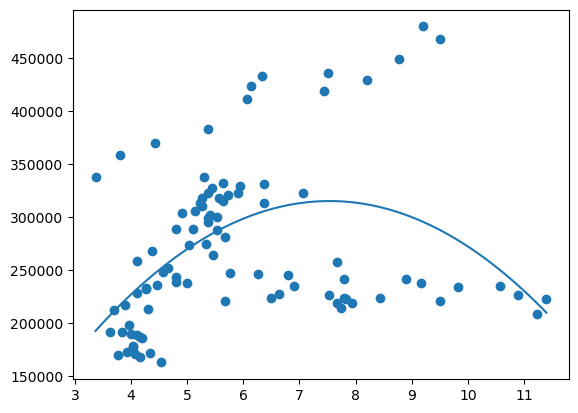

0.20093110642414314 Weak candidate for Polynomial Regression


In [8]:
#Polynomial Regression
x_pr = housing_data_df['MSACSR']
y_pr = housing_data_df['MSPUS']

mymodel = np.poly1d(np.polyfit(x_pr, y_pr, 2))
myline = np.linspace(min(x_pr), max(x_pr), 100)

plt.scatter(x_pr, y_pr)
plt.plot(myline, mymodel(myline))
plt.show()

r2s = r2_score(y_pr, mymodel(x_pr))

if r2s > 0.9:
    print(f'{r2s}: Good candidate for Polynomial Regression')
else:
    print(f'{r2s} Weak candidate for Polynomial Regression')

### Try Multiple Regression (i.e. linear regression with multiple variables)

In [9]:
# Create X df
X = housing_data_df.copy().drop(columns='MSPUS')
X.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2000 2  171.433333  1586.666667  103.699000   139.566667       116047.0   
     3  173.000000  1503.666667  106.459333   141.780000       116482.0   
     4  174.233333  1544.000000  108.270000   144.200000       116914.0   
2001 1  175.900000  1605.000000  109.750000   146.910000       117347.0   
     2  177.133333  1630.000000  112.241000   149.316667       117786.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  
2000 2   233.89   145.166667   245.58      8.316154      7.991538  4.533333  
     3   238.16   143.833333   249.63      8.020000      7.733077  4.166667  
     4   241.80   142.833333   252.46      7.620769      7.294615  3.933333  
2001 1   247.79   142.266667   255.77      7.006923      6.589231  3.766667  
     2   251.94   143.666667   260.21      7.130000      6.660000  4.033333

In [10]:
#Create y df
y = housing_data_df[['MSPUS']]
y.head()

MSPUS
2000 2  163200.0
     3  168800.0
     4  172900.0
2001 1  169800.0
     2  179000.0

In [11]:
split = round(abs(X.index.min()[0] - X.index.max()[0]) * 0.8)
split

18

In [12]:
# Slice data by date to split testing and training data

#Start
training_begin = X.index.min()[0]
training_end = X.index.min()[0] + split

display(training_begin)
display(training_end)

2000

2018

In [13]:
# Split the train data
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.tail()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2017 4  247.238333  1235.666667  195.461667   248.006667       137637.0   
2018 1  249.321667  1298.000000  197.195000   252.636667       137920.0   
     2  250.679000  1275.000000  202.370333   255.630000       138203.0   
     3  251.686333  1248.666667  205.216667   258.863333       138488.0   
     4  252.711000  1165.666667  205.056667   261.856667       138778.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  
2017 4   403.58   223.966667   335.72      3.922308      3.290769  5.300000  
2018 1   409.26   228.600000   337.40      4.282308      3.740000  5.633333  
     2   416.79   236.133333   339.57      4.544615      4.014615  5.633333  
     3   421.88   239.666667   340.73      4.566923      4.033846  6.366667  
     4   423.32   238.600000   340.14      4.784615      4.212308  7.066667

In [14]:
#Split the test data
X_test = X.loc[training_end+1:]
y_test = y.loc[training_end+1:]

X_test.isna().any()

CPIAUCSL         False
HOUST            False
CSUSHPINSA       False
HPIPONM226S      False
ETOTALUSQ176N    False
USSTHPI          False
WPUSI012011      False
ILSTHPI          False
MORTGAGE30US     False
MORTGAGE15US     False
MSACSR           False
dtype: bool

In [15]:
# Scale features

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
""" 
Linear Regression finds the 'best fit' line representing the relationship between dependent variable (y)
and independent features
"""
from sklearn.linear_model import LinearRegression 
model = LinearRegression() 
model.fit(X_train_scaled, y_train)

LinearRegression()

In [17]:
print(f"Model's slope: {model.coef_}") 

Model's slope: [[ 42759.08091435   9274.91954663  27859.70094362  30756.89883235
    8036.57513398 -39452.90801128 -14513.13516268  -7969.69006994
  -37900.60411618  38703.80724143   3136.83942133]]


In [18]:
predicted_y_values = model.predict(X_test_scaled) 

In [19]:
# Create a copy of the original data
housing_predictions_df = housing_data_df.copy().loc[training_end+1:]

# Add a column with the predicted sales values
housing_predictions_df["MSPUS_lr_predicted"] = predicted_y_values

# Display sample data
housing_predictions_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2019 1  253.385667  1185.000000  204.805333   265.070000       139069.0   
     2  255.247333  1267.333333  209.215000   268.286667       139360.0   
     3  256.089333  1304.000000  211.642667   271.656667       139655.0   
     4  257.888000  1409.666667  212.109667   276.390000       139961.0   
2020 1  258.767333  1468.000000  213.609333   281.653333       140266.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2019 1   428.05   238.233333   343.17      4.373846      3.815385  6.366667   
     2   435.20   236.933333   348.17      4.010769      3.464615  5.900000   
     3   440.74   234.800000   351.52      3.658462      3.129231  5.566667   
     4   444.66   232.933333   353.19      3.700000      3.157692  5.433333   
2020 1   449.81   234.766667   354.77      3.521538      2.983077  5.933333   

           MSPUS  MSPUS_lr_predicted  
2019 1  313000.0       338206.066520  
     2  322500.0       345529.091282  
     3  318400.0       350694.428748  
     4  327100.0       358373.820659  
2020 1  329000.0       364294.770102

<Axes: >

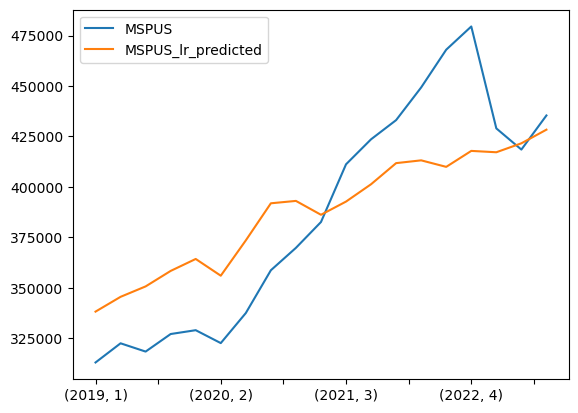

In [20]:
housing_predictions_df[['MSPUS', 'MSPUS_lr_predicted']].plot()

In [21]:
# Create a decision tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
decision_tree_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
housing_predictions_df["MSPUS_dt_predicted"] = y_pred

decision_tree_model.feature_importances_

Mean Squared Error: 5997293684.210526


array([0.01231137, 0.01683648, 0.00394788, 0.04758286, 0.71691597,
       0.00205845, 0.17889304, 0.01569461, 0.0008183 , 0.00312922,
       0.00181182])

<Axes: >

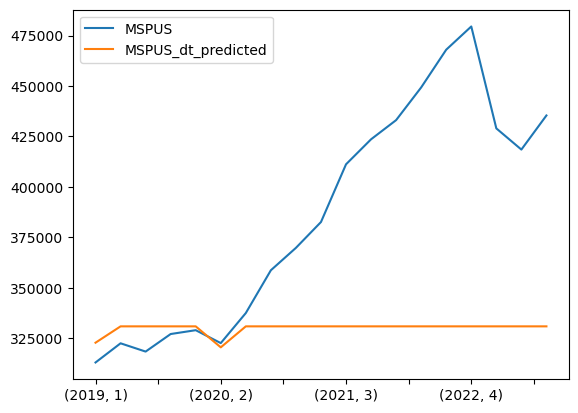

In [22]:
housing_predictions_df[['MSPUS', 'MSPUS_dt_predicted']].plot()

In [23]:
# Create a Random Forest Regressor model
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model
random_forest_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
housing_predictions_df["MSPUS_rfr_predicted"] = y_pred

Mean Squared Error: 6297248238.105263


<Axes: >

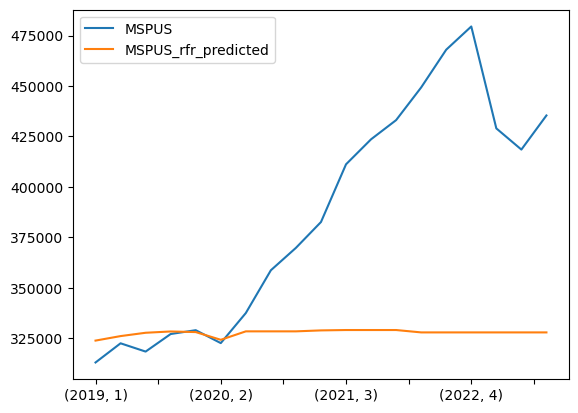

In [24]:
housing_predictions_df[['MSPUS', 'MSPUS_rfr_predicted']].plot()

In [25]:
model = Sequential()
number_inputs = len(X_train_scaled[0])
model.add(Dense(units=6, activation="relu", input_dim=number_inputs)) 
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

In [26]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Transform test data using the same scaler
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

model.summary()

Epoch 1/50
2/2 [==============================] - 1s 141ms/step - loss: 0.6565 - val_loss: 1.3813
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6188 - val_loss: 1.3175
Epoch 3/50
2/2 [==============================] - 0s 37ms/step - loss: 0.5828 - val_loss: 1.2552
Epoch 4/50
2/2 [==============================] - 0s 32ms/step - loss: 0.5470 - val_loss: 1.1951
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.5131 - val_loss: 1.1357
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.4802 - val_loss: 1.0778
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.4480 - val_loss: 1.0216
Epoch 8/50
2/2 [==============================] - 0s 22ms/step - loss: 0.4181 - val_loss: 0.9665
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 0.3883 - val_loss: 0.9126
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.3594 - val_loss: 0.8598
Epoch 11/50
2/2 [===========

In [27]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_pred

1/1 [==============================] - 0s 73ms/step


array([[350809.62],
       [366281.03],
       [380645.47],
       [380507.56],
       [391236.16],
       [416357.2 ],
       [410094.4 ],
       [436169.4 ],
       [459694.94],
       [484320.78],
       [516179.88],
       [528584.75],
       [532292.4 ],
       [495795.2 ],
       [493278.06],
       [456303.8 ],
       [480646.84],
       [484082.03],
       [481020.5 ]], dtype=float32)

In [28]:
housing_predictions_df["MSPUS_neural_predicted"] = y_pred

<Axes: >

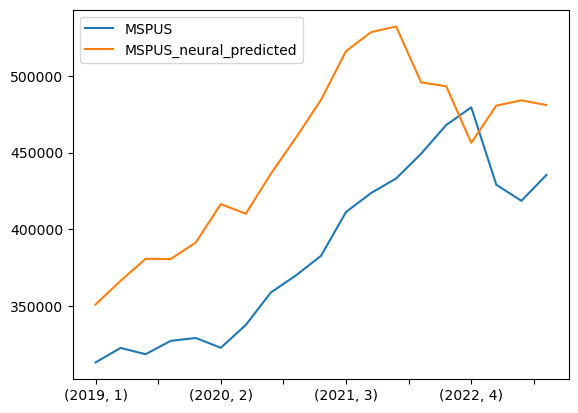

In [29]:
housing_predictions_df[['MSPUS', 'MSPUS_neural_predicted']].plot()

In [30]:
housing_predictions_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  ETOTALUSQ176N  \
2019 1  253.385667  1185.000000  204.805333   265.070000       139069.0   
     2  255.247333  1267.333333  209.215000   268.286667       139360.0   
     3  256.089333  1304.000000  211.642667   271.656667       139655.0   
     4  257.888000  1409.666667  212.109667   276.390000       139961.0   
2020 1  258.767333  1468.000000  213.609333   281.653333       140266.0   

        USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  MORTGAGE15US    MSACSR  \
2019 1   428.05   238.233333   343.17      4.373846      3.815385  6.366667   
     2   435.20   236.933333   348.17      4.010769      3.464615  5.900000   
     3   440.74   234.800000   351.52      3.658462      3.129231  5.566667   
     4   444.66   232.933333   353.19      3.700000      3.157692  5.433333   
2020 1   449.81   234.766667   354.77      3.521538      2.983077  5.933333   

           MSPUS  MSPUS_lr_predicted  MSPUS_dt_predicted  MSPUS_rfr_predicted  \
2019 1  313000.0       338206.066520            322800.0             323846.0   
     2  322500.0       345529.091282            330900.0             326076.0   
     3  318400.0       350694.428748            330900.0             327723.0   
     4  327100.0       358373.820659            330900.0             328369.0   
2020 1  329000.0       364294.770102            330900.0             328064.0   

        MSPUS_neural_predicted  
2019 1            350809.62500  
     2            366281.03125  
     3            380645.46875  
     4            380507.56250  
2020 1            391236.15625

<Axes: >

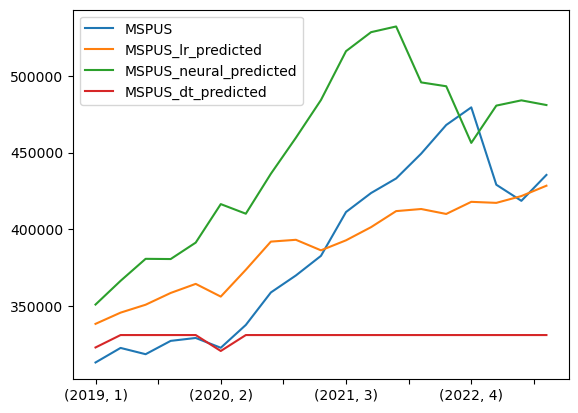

In [31]:
housing_predictions_df[['MSPUS', 'MSPUS_lr_predicted', 'MSPUS_neural_predicted', 'MSPUS_dt_predicted']].plot()